In [ ]:
from fileinput import filename
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

#initialize dataframe
df_main=pd.DataFrame()
datadir="data"

#semi channel height
DELTA=1.0

for dir in os.listdir(path=datadir):
    
    temp = dict()
    name,mesh =dir.split(sep="_")

    #TODO
    #"""
    types=["lowRe","highRe"]
    Re_taus=[550.0,9e4] #calculated using the approx formula of the pope book Re_tau=0.09*Re^0.88
    Res=[20e3,6.67e6]
    nus=[1e-4,3e-7]
    for i,type in enumerate(types):
        if type in name:
            RE_TAU=Re_taus[i]
            NU=nus[i]
            U_TAU=RE_TAU*NU/DELTA
            #print(U_TAU)
            temp["nu"]=NU
            temp["Re_tau"]=Re_taus[i]
            temp["type"]= type
            temp["model_name"] = name.removeprefix(type)
    #    """
    #temp["model_name"] = name
    temp["mesh"] = mesh
    
    path=datadir+'/'+dir
    for dir2 in os.listdir(path=path):
        path2=path+'/'+dir2

        if dir2 == "yPlus":
            filename=path2+'/0/yPlus.dat'
            #iter,patch,max,min,average=np.loadtxt(filename,skiprows=1,comments=None,unpack=True)
            yPlus=np.loadtxt(filename,skiprows=2,usecols=4,comments="#")
            temp["yPlus_average"]=yPlus[-1]

        if dir2 == "yProfilesGraph":
            dirs=os.listdir(path=path2)
            iters = [int(temp) for temp in dirs]

            finalIter=max(iters)
            path3=path2+'/'+str(finalIter)
            file=os.listdir(path=path3)
            filename=path3+'/'+file[0]
            y,epsilon,k,nut,Ux=np.loadtxt(filename,skiprows=1,usecols=(0,1,2,3,4),
                                unpack=True,delimiter=",")
            
            # in wall units
            temp["y"]=y*RE_TAU/DELTA
            temp["epsilon"]=epsilon*DELTA/(RE_TAU * U_TAU**3)
            temp["k"]=k/(U_TAU*U_TAU)
            temp["nut"]=nut*RE_TAU/DELTA/U_TAU
            temp["U"]=Ux/U_TAU
            """
            # phisical units
            temp["y"]=y
            temp["epsilon"]=epsilon
            temp["k"]=k
            temp["nut"]=nut
            temp["U"]=Ux
            """

    df_temp=pd.DataFrame(temp)
    df_main=pd.concat([df_main,df_temp],ignore_index=True,copy=True)

print(df_main.size)


In [31]:
#read dns data
dns=pd.read_csv("dnsRE_TAU550.csv")
dns["model_name"]="DNS"
dns.set_index("y+",inplace=True)

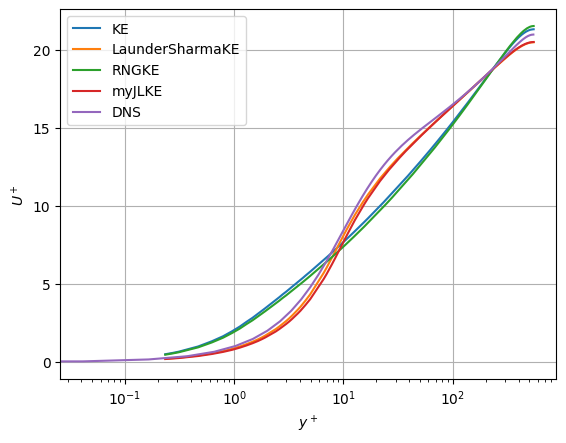

In [36]:
#plots
IMAGEDIR="figures/"
#fine mesh
df_fine=df_main[df_main["mesh"] == "fine"]
df_fine=df_fine[df_fine["type"] == "lowRe"]
df_fine.set_index("y",inplace=True)

#velocity profiles
fig, ax=plt.subplots()
df_fine.groupby("model_name")["U"].plot(ax=ax,logx=True)
dns.groupby("model_name")["U+"].plot(ax=ax,logx=True)
ax.legend()
ax.grid()
ax.set_ylabel(r"$U^+$")
ax.set_xlabel(r"$y^+$")
fig.savefig(IMAGEDIR+"velocity_profiles")


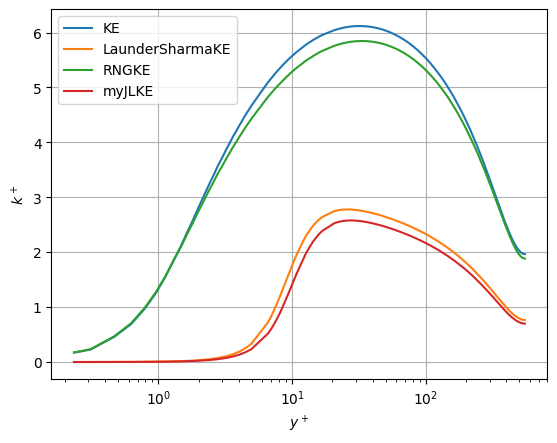

In [46]:
#fine grid
#turbulent energy
fig, ax=plt.subplots()
df_fine.groupby("model_name")["k"].plot(ax=ax,logx=True)
ax.legend()
ax.grid()
ax.set_ylabel(r"$k^+$")
ax.set_xlabel(r"$y^+$")

fig.savefig(IMAGEDIR+"turbulentEnergy")


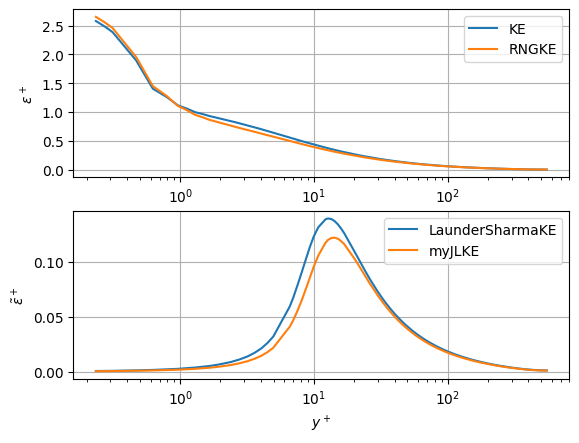

In [61]:
#fine grid
#dissipation rate for RNGKE and KE
fig, ax=plt.subplots(2)
df_fine[df_fine["model_name"].isin(["RNGKE","KE"])].groupby("model_name")["epsilon"].plot(ax=ax[0],logx=True)
ax[0].legend()
ax[0].grid()
ax[0].set_ylabel(r"$\epsilon^+$")
ax[0].set_xlabel(r"$y^+$")

#fig.savefig(IMAGEDIR+"dissipationRate")

# modified diffipation rate for JL and LaunderSharma
#fig, ax=plt.subplots()
df_fine[df_fine["model_name"].isin(["myJLKE","LaunderSharmaKE"])].groupby("model_name")["epsilon"].plot(ax=ax[1],logx=True)
ax[1].legend()
ax[1].grid()
ax[1].set_ylabel(r"$\tilde{\epsilon}^+$")
ax[1].set_xlabel(r"$y^+$")

fig.savefig(IMAGEDIR+"dissipationRate")

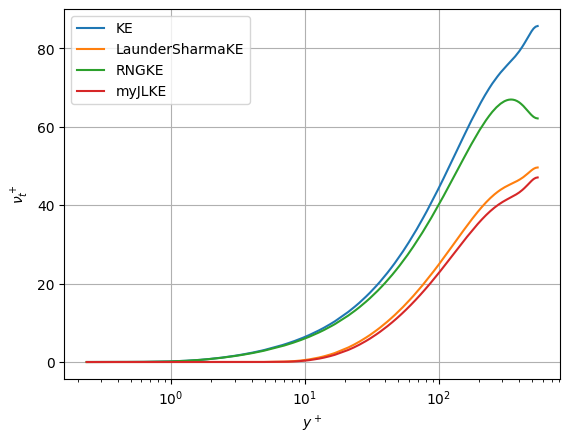

In [47]:
#fine grid
#turbulent viscosity
fig, ax=plt.subplots()
df_fine.groupby("model_name")["nut"].plot(ax=ax,logx=True)
ax.legend()
ax.grid()
ax.set_ylabel(r"$\nu_t^+$")
ax.set_xlabel(r"$y^+$")

fig.savefig(IMAGEDIR+"turbulentViscosity")

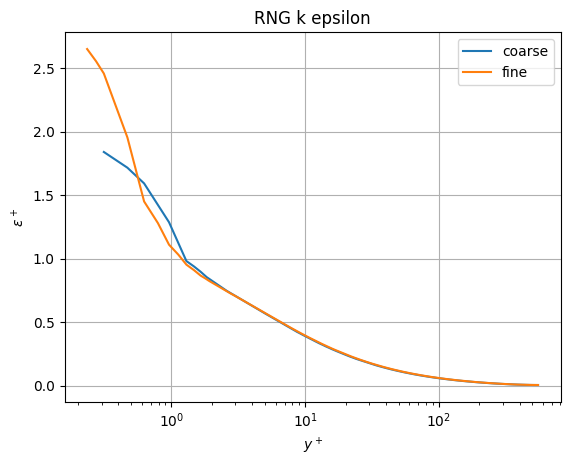

In [78]:
#coarse vs fine grid: RNGKE
# only differences in epsilon
model="RNGKE"
df_coarse=df_main[(df_main["mesh"] == "coarse")&(df_main["type"]=="lowRe")]
df_coarse=df_coarse[df_coarse["model_name"]==model]
df_coarse.set_index("y",inplace=True)

fig, ax= plt.subplots()
variables=["epsilon"]
df_coarse.plot(y=variables,ax=ax,logx=True)
df_fine[df_fine["model_name"]==model].plot(y=variables,ax=ax,logx=True)
ax.legend(["coarse","fine"])
ax.grid()
ax.set_ylabel(r"$\epsilon^+$")
ax.set_xlabel(r"$y^+$")
ax.set_title("RNG k epsilon")

fig.savefig(IMAGEDIR+"coarse_fine")

In [ ]:
#useless if you already have the .csv file
dns=pd.read_csv("dnsRE_TAU550.dat", sep=" ",comment="%",
                skipinitialspace=True,skiprows=23)
dns.to_csv("dnsRE_TAU550.csv",index=False)